<a href="https://colab.research.google.com/github/lijingwang/hbvpy/blob/main/HBV_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/lijingwang/hbvpy.git
%cd hbvpy

Cloning into 'hbvpy'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 52 (delta 21), reused 33 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 2.13 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (21/21), done.
/content/hbvpy


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import hbv
from hbv import hbv_run
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'

# Load inputs: temperature, precipitation and monthly PET

In [3]:
example_dir = Path("examples") / "Prof_Amir_AghaKouchak_example"

forcing_path = example_dir / "inputPrecipTemp.csv"
pet_path = example_dir / "inputMonthlyTempEvap.csv"
Qobs_path = example_dir / "Qobs.csv"

forcing = pd.read_csv(forcing_path, parse_dates=["Time"])
forcing["Time"] = pd.to_datetime(forcing["Time"], format="%Y-%m-%d")
pet = pd.read_csv(pet_path)

Qobs = pd.read_csv(Qobs_path, parse_dates=["Time"])
Qobs["Time"] = pd.to_datetime(Qobs["Time"], format="%Y-%m-%d")

In [4]:
forcing.head() # Time, Month, Temperature (deg C),	Precipitation (mm/day)

,Time,Month,Temperature,Precipitation
0,1991-01-01,1,-1.5,0.4
1,1991-01-02,1,-0.8,10.5
2,1991-01-03,1,-2.8,0.9
3,1991-01-04,1,-3.7,4.4
4,1991-01-05,1,-6.1,0.6


Text(0.5, 1.0, 'Temperature (deg C)')

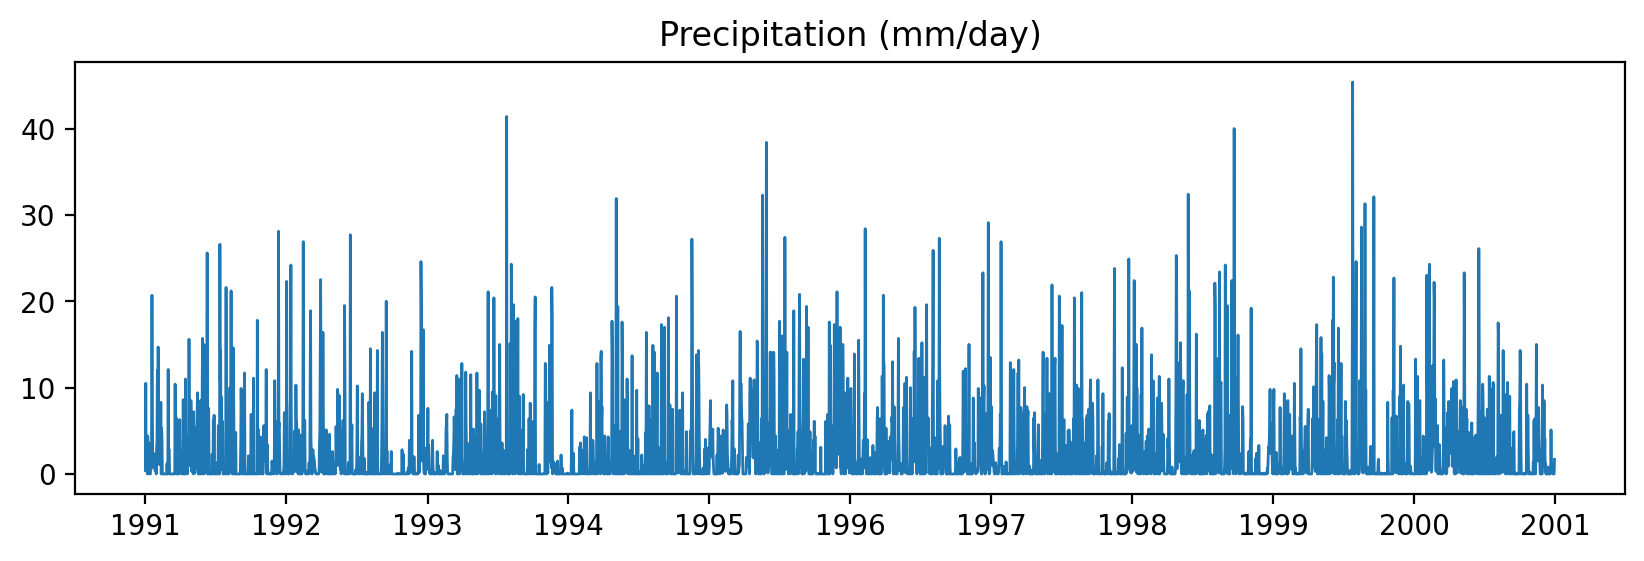

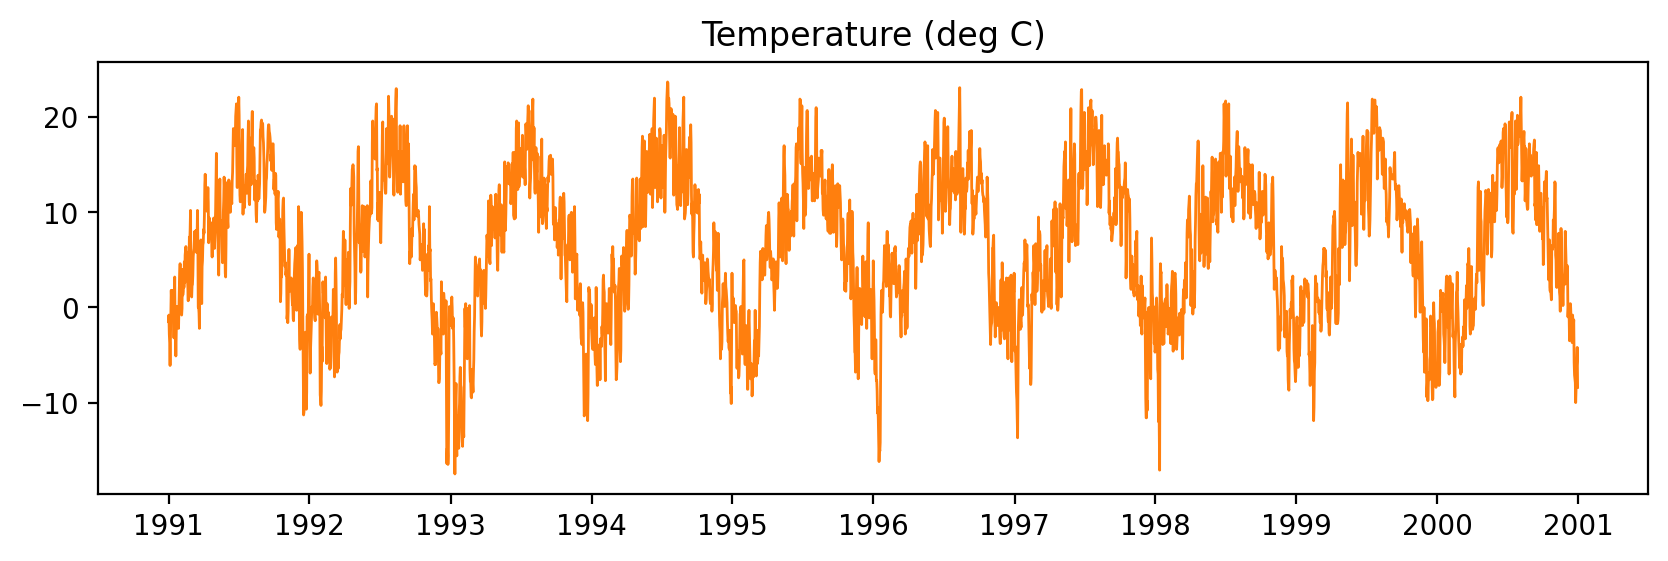

In [5]:
fig, ax = plt.subplots(figsize=(10, 2.8))
ax.plot(forcing["Time"], forcing["Precipitation"], lw=1, c = 'C0')
ax.set_title('Precipitation (mm/day)')
fig, ax = plt.subplots(figsize=(10, 2.8))
ax.plot(forcing["Time"], forcing["Temperature"], lw=1, c = 'C1')
ax.set_title('Temperature (deg C)')

In [6]:
pet.head() # Corresponding Month, Average Temperature each month, Average PET per month (mm/month), Average PET per day (mm/day)

,month,T_avg_month,PEm_month,PEm_day
0,1,1.4,5,0.161
1,2,-0.3,5,0.179
2,3,2.6,20,0.645
3,4,6.3,50,1.667
4,5,10.9,95,3.065


## Need to find your own precipitation, temperature and potential monthly ET dataset?

You can use your own source for sure. Here are just generic methods for you to find your inputs.



*   High-resolution gridded PRISM weather data, with mean temp and precipitation: https://prism.oregonstate.edu/explorer/
*   MODIS-ET: https://modis.gsfc.nasa.gov/data/dataprod/mod16.php.
*How to get MODIS-ET tutorial: https://youtu.be/cUAtYyGI9mI?si=qzb8bkKHAI_iHKb6*






# Initialize parameters


[d, fc, beta, cpar, k0, lthr, k1, k2, kp, pwp], where

d    : degree day melt factor (mm/degC/day)

fc   : field capacity (mm)

beta : runoff nonlinearity exponent

cpar : PET temperature correction factor

k0   : quickflow coefficient for s1 above threshold lthr (1/day)

lthr : threshold in upper storage for quickflow activation (mm)

k1   : linear outflow coefficient from s1 (1/day)

k2   : linear outflow coefficient from s2 (1/day)

kp   : percolation coefficient from s1 to s2 (1/day)

pwp  : permanent wilting point (mm)


In [7]:
ParamInitial = {
    "d": 2.74,
    "fc": 200.0,
    "beta": 2.0,
    "cpar": 0.1,
    "k0": 0.2,
    "lthr": 5,
    "k1": 0.05,
    "k2": 0.05,
    "kp": 0.05,
    "pwp": 100.0,
}

params = np.array([ParamInitial[k] for k in ParamInitial.keys()], dtype=float)

# Run the HBV model

In [8]:
results, aux = hbv_run(
    forcing=forcing,
    pet_monthly=pet,
    params=params,
    area_km2=410.0, # catchment size 410 km2 !! You need to change the catchment size/drainage area for your own site!!!
    Tsnow_thresh=0.0, # threshold for being snow or rain
    init_state={"snow": 0.0, "soil": 0.0, "s1": 0.0, "s2": 0.0},
)
results.head()

,Time,snow,liq_water,pe,ea,soil,dq,s1,s2,q_mmday,Q_m3s
0,1991-01-01,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1991-01-02,10.5,0.0,0.12558,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1991-01-03,11.4,0.0,0.09338,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1991-01-04,15.8,0.0,0.07889,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1991-01-05,16.4,0.0,0.04025,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Compare simulated and observed discharge Q (m3/s)

Recall that we put all storage terms initially as zero: {"snow": 0.0, "soil": 0.0, "s1": 0.0, "s2": 0.0}, do you see any impact? Do you think if you can give better initial values?

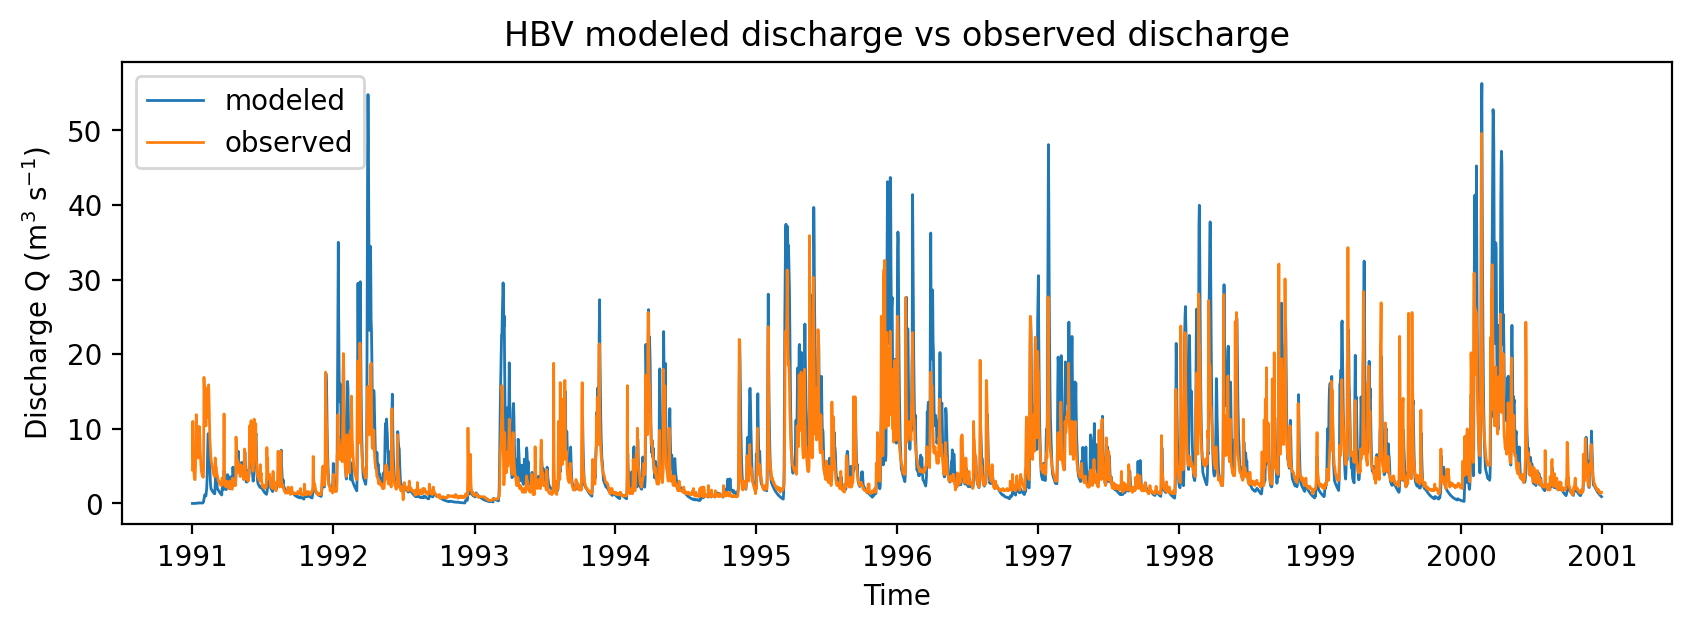

In [9]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(results["Time"], results["Q_m3s"], lw=1, label = 'modeled')
ax.plot(Qobs["Time"], Qobs["Q (m3/s)"], lw=1, label = 'observed')
ax.set_xlabel("Time")
ax.set_ylabel("Discharge Q (m$^3$ s$^{-1}$)")
ax.set_title("HBV modeled discharge vs observed discharge")
ax.legend()
plt.show()

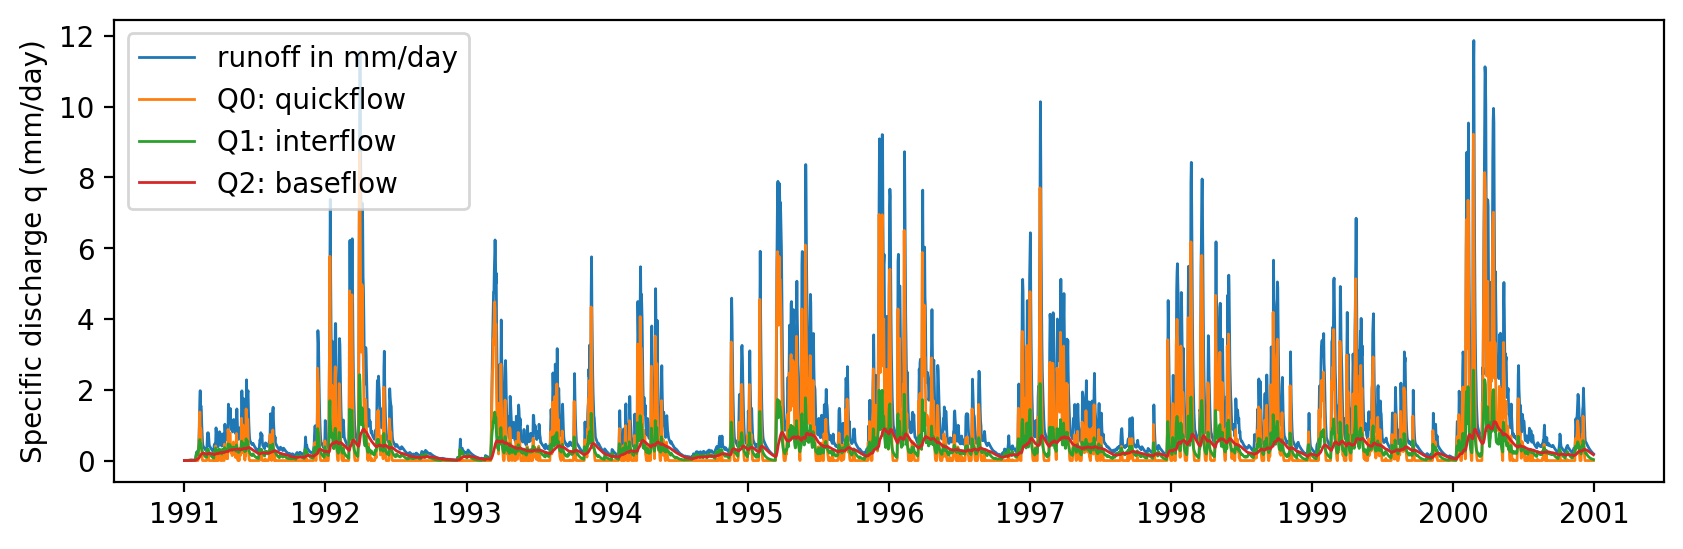

In [10]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(results["Time"], results["q_mmday"], lw=1, label = 'runoff in mm/day')
Q0 = ((results["s1"]-ParamInitial['lthr'])*ParamInitial['k0']).clip(lower=0.0)
ax.plot(results["Time"], Q0, lw=1, label = 'Q0: quickflow')
Q1 = results["s1"]*ParamInitial['k1']
ax.plot(results["Time"], Q1, lw=1, label = 'Q1: interflow')
Q2 = results["s2"]*ParamInitial['k2']
ax.plot(results["Time"], Q2, lw=1, label = 'Q2: baseflow')
ax.legend()
ax.set_ylabel("Specific discharge q (mm/day)")
plt.show()

# Metrics

In [11]:
from metrics import discharge_metrics

scores = discharge_metrics(
    modeled=results,
    observed=Qobs,
    modeled_value_col="Q_m3s",
    observed_value_col="Q (m3/s)",
)

scores

{'MSE': 21.193327188186615,
 'RMSE': 4.603621095201756,
 'MAE': 2.4225935459152264,
 'NSE': 0.13633572485909307,
 'KGE': 0.4701972580631941}

# Other state/flux variables

snow: snow water equivalent storage (mm)

liq_water: liquid water, rain + melt available to soil/runoff (mm/day)

pe: potential evapotranspiration (mm/day)
   
ea: actual evapotranspiration (mm/day)

soil: soil moisture storage (mm)
    
dq: effective precipitation to reservoirs (mm/day)

s1: upper reservoir storage (mm)

s2: lower reservoir storage (mm)
    
q_mmday: runoff depth equivalent (mm/day)

Q_m3s: discharge (m^3/s)

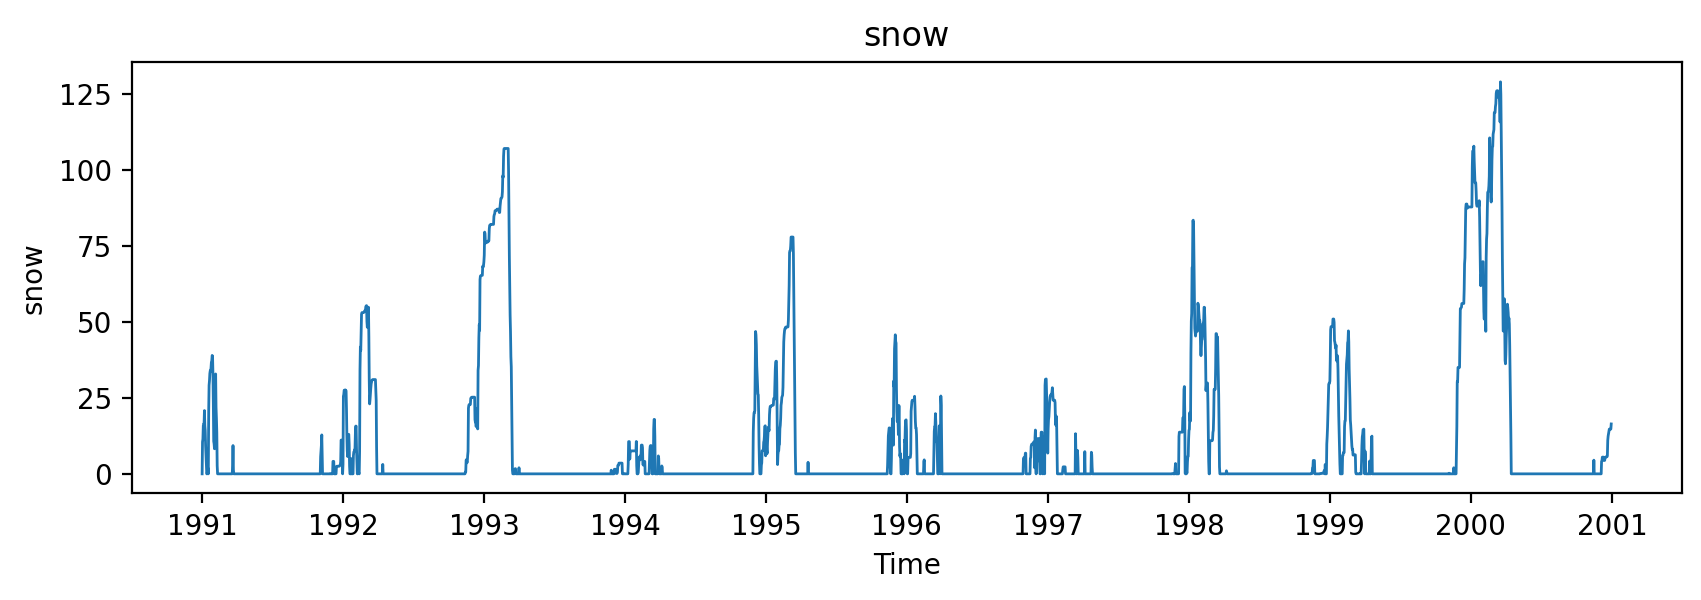

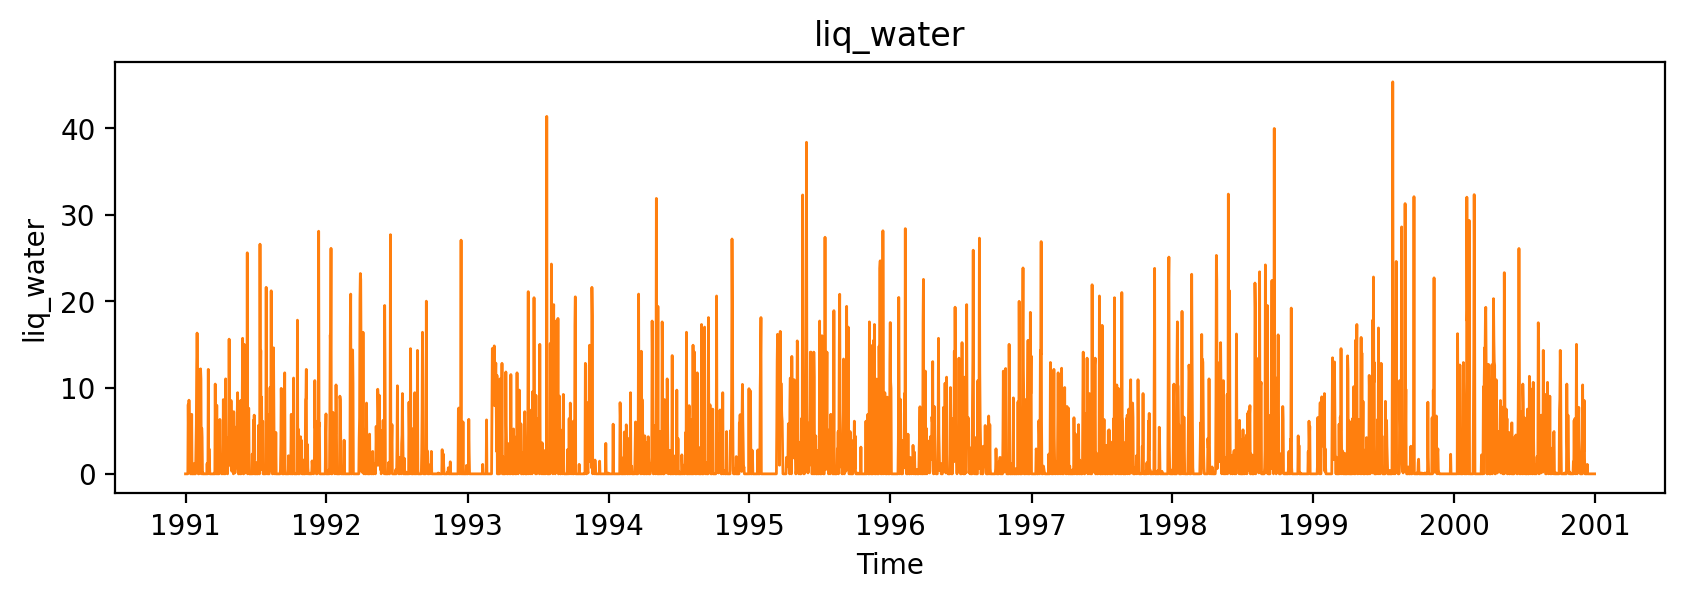

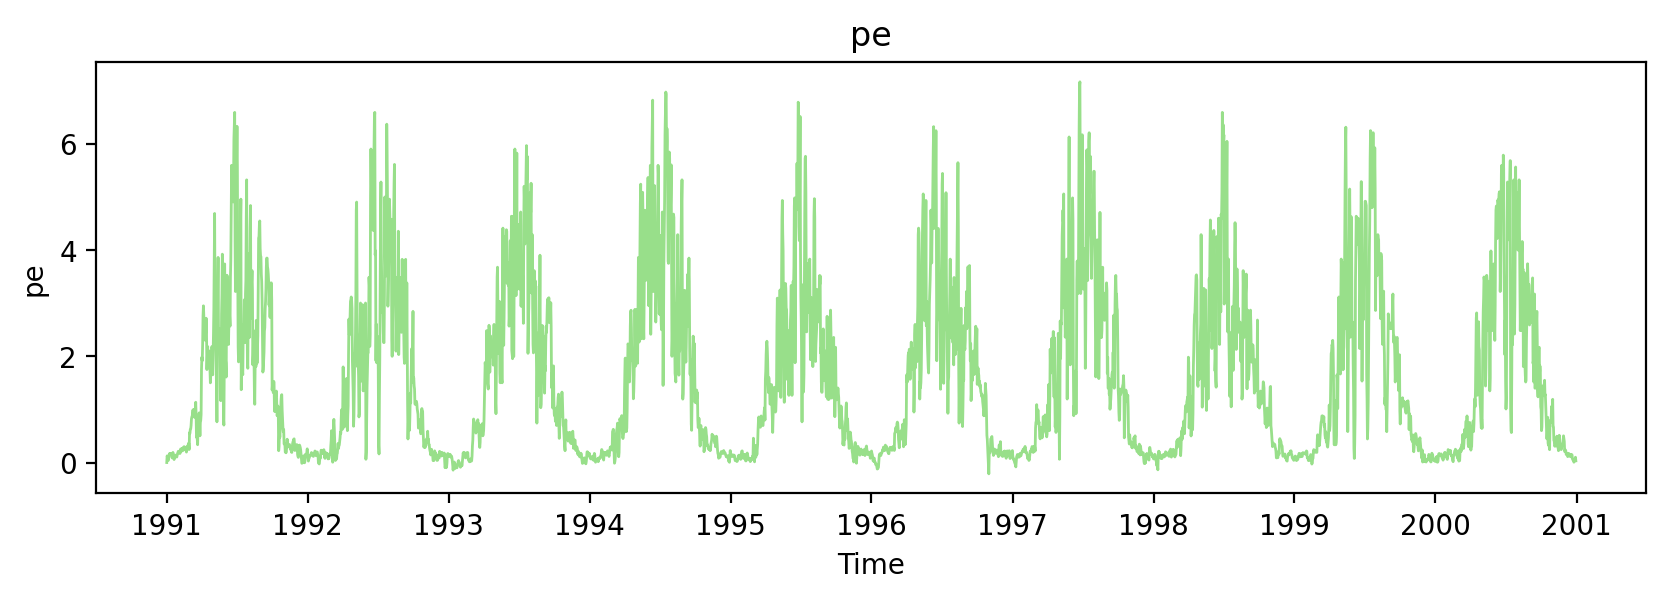

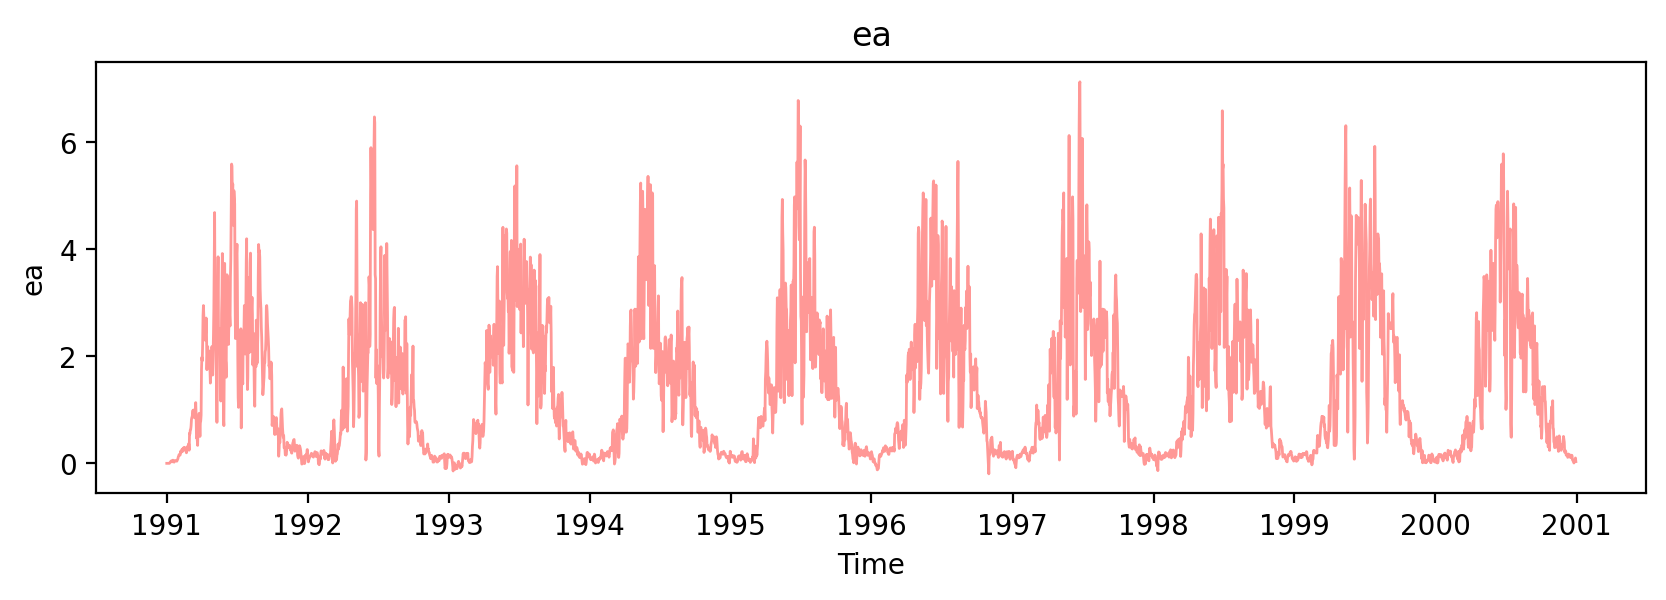

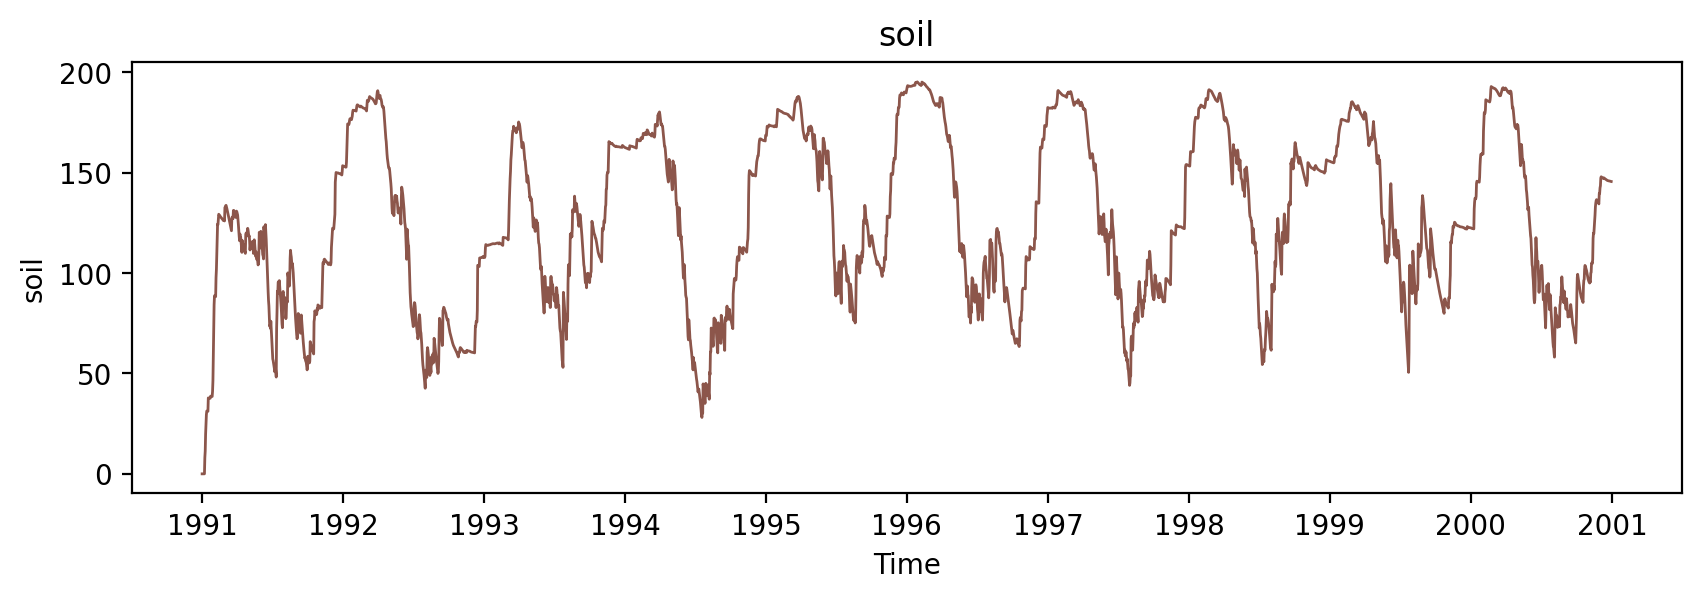

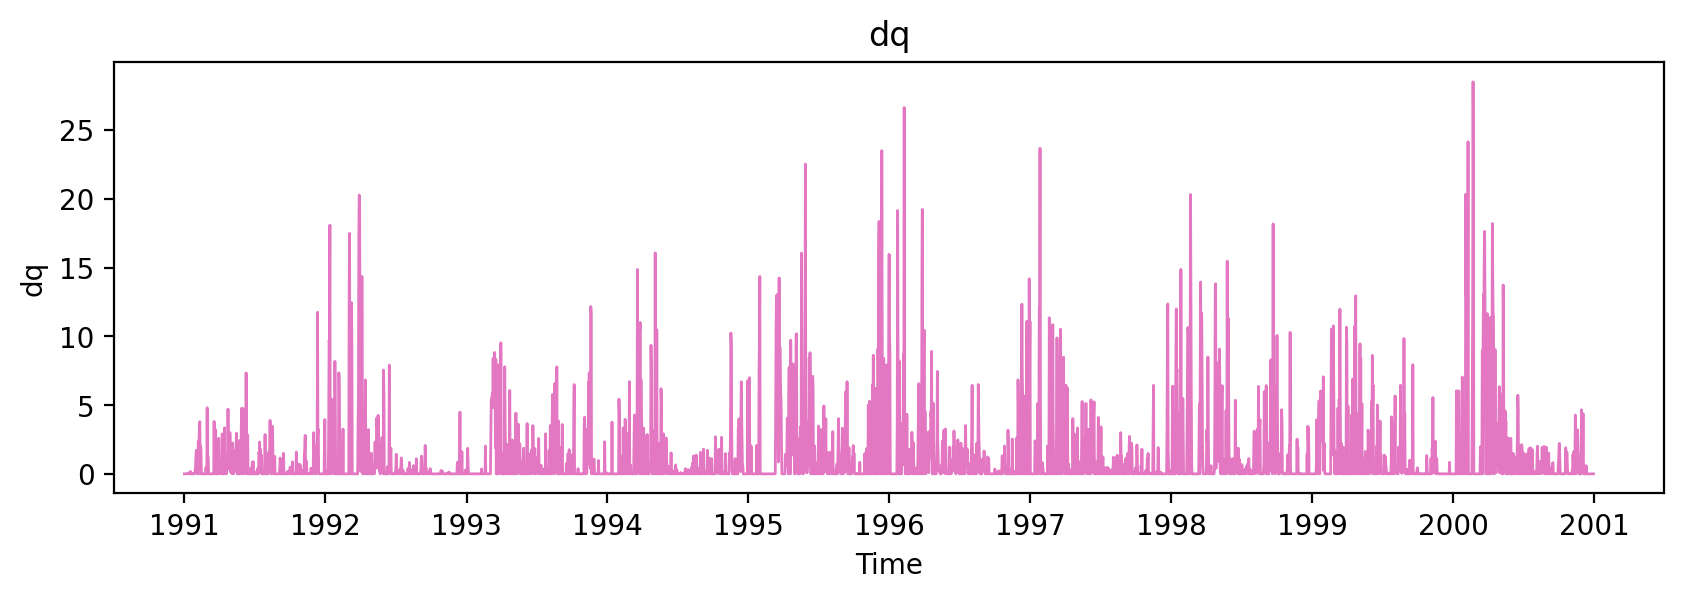

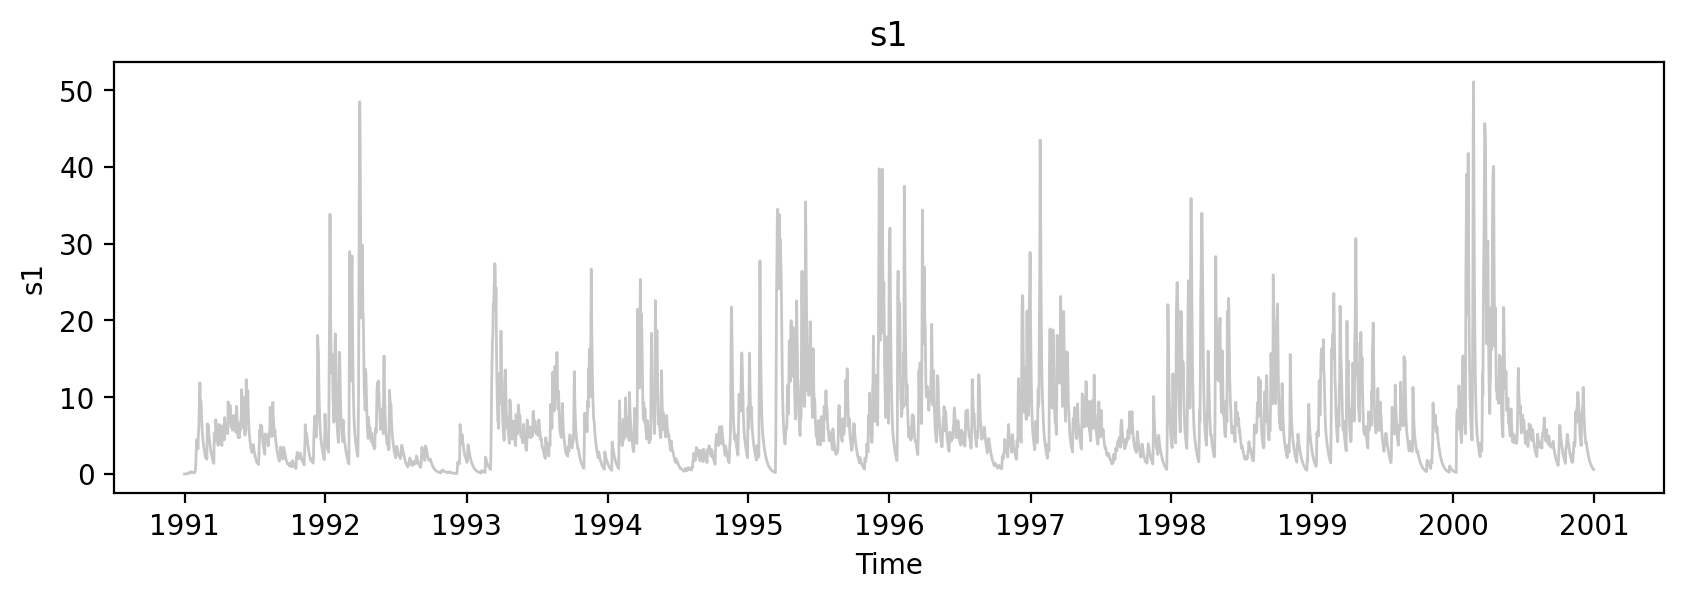

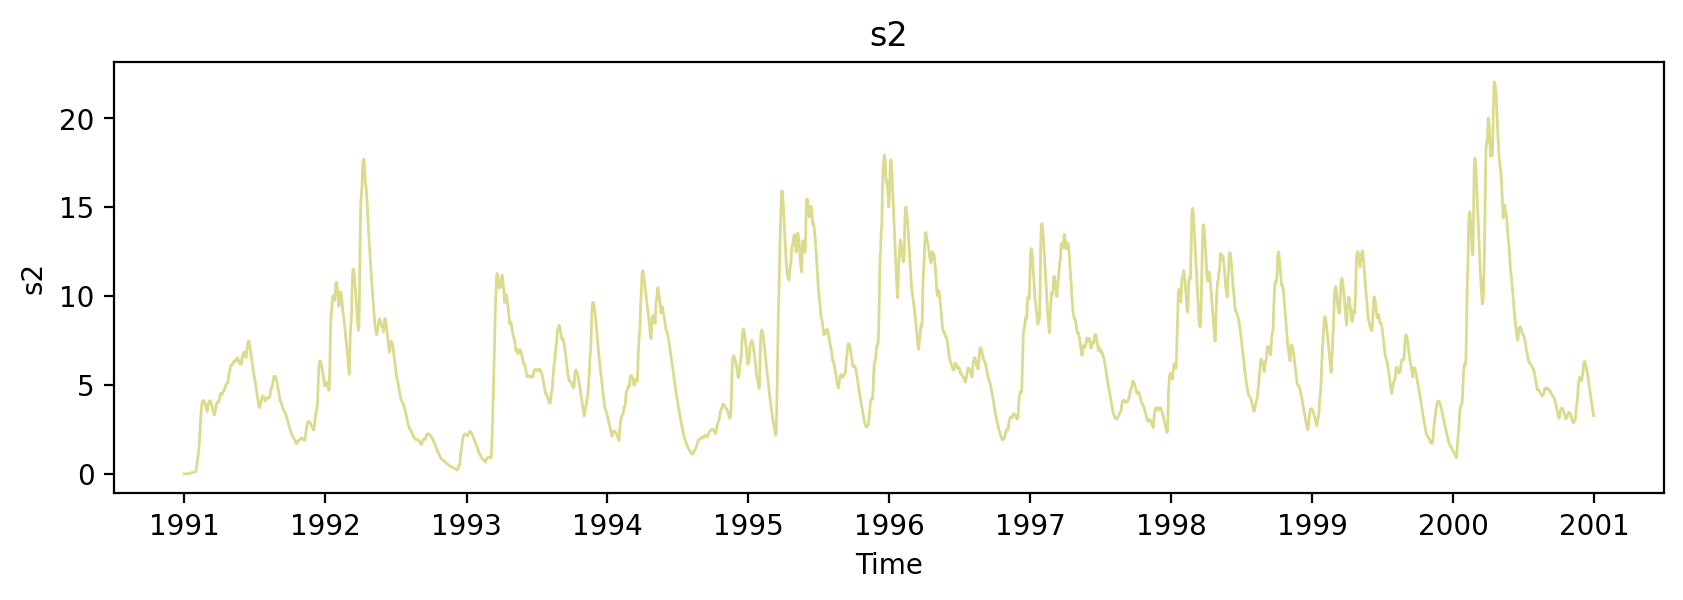

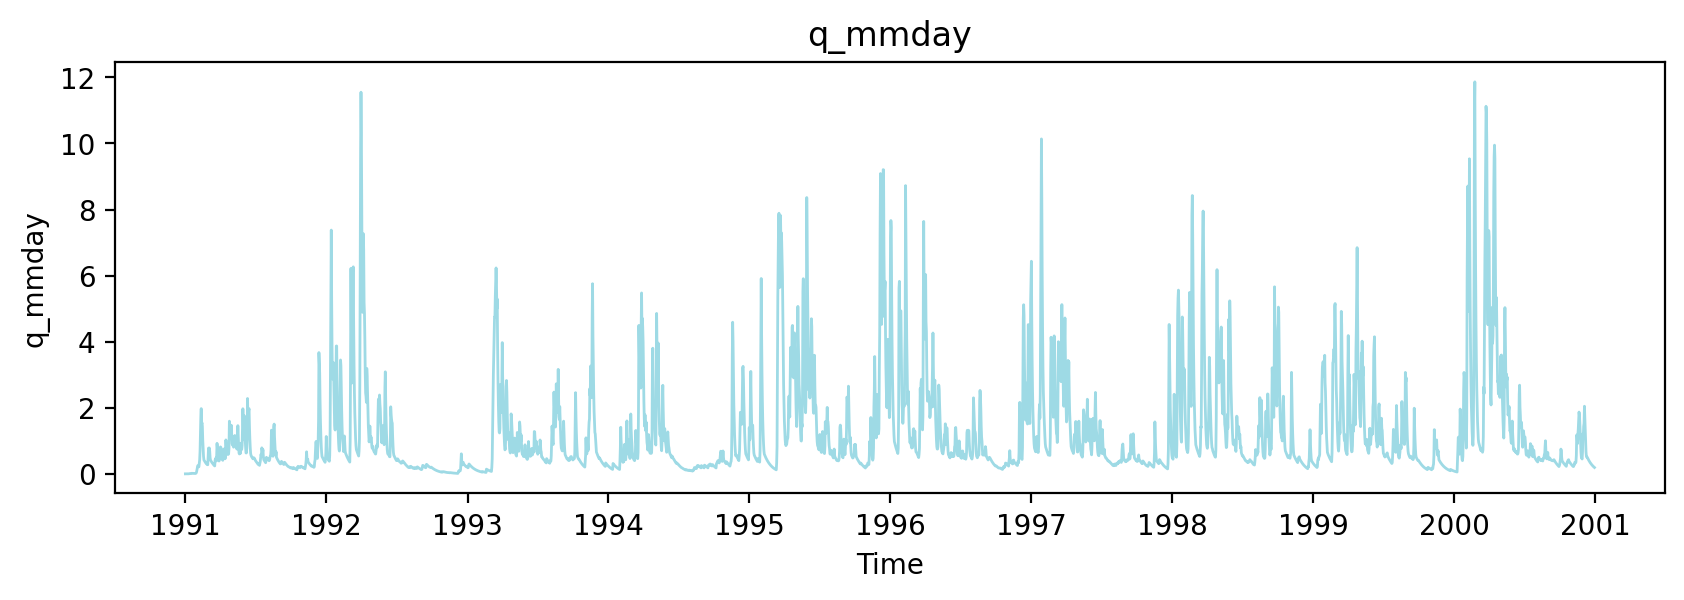

In [12]:
vars_to_plot = [c for c in results.columns if c not in ["Time", "Q_m3s"]]
colors = plt.cm.tab20(np.linspace(0, 1, len(vars_to_plot)))

for v, col in zip(vars_to_plot, colors):
    fig, ax = plt.subplots(figsize=(10, 2.8))
    ax.plot(results["Time"], results[v], lw=1, color=col)
    ax.set_xlabel("Time")
    ax.set_ylabel(v)
    ax.set_title(v)
    plt.show()

## S1 and L

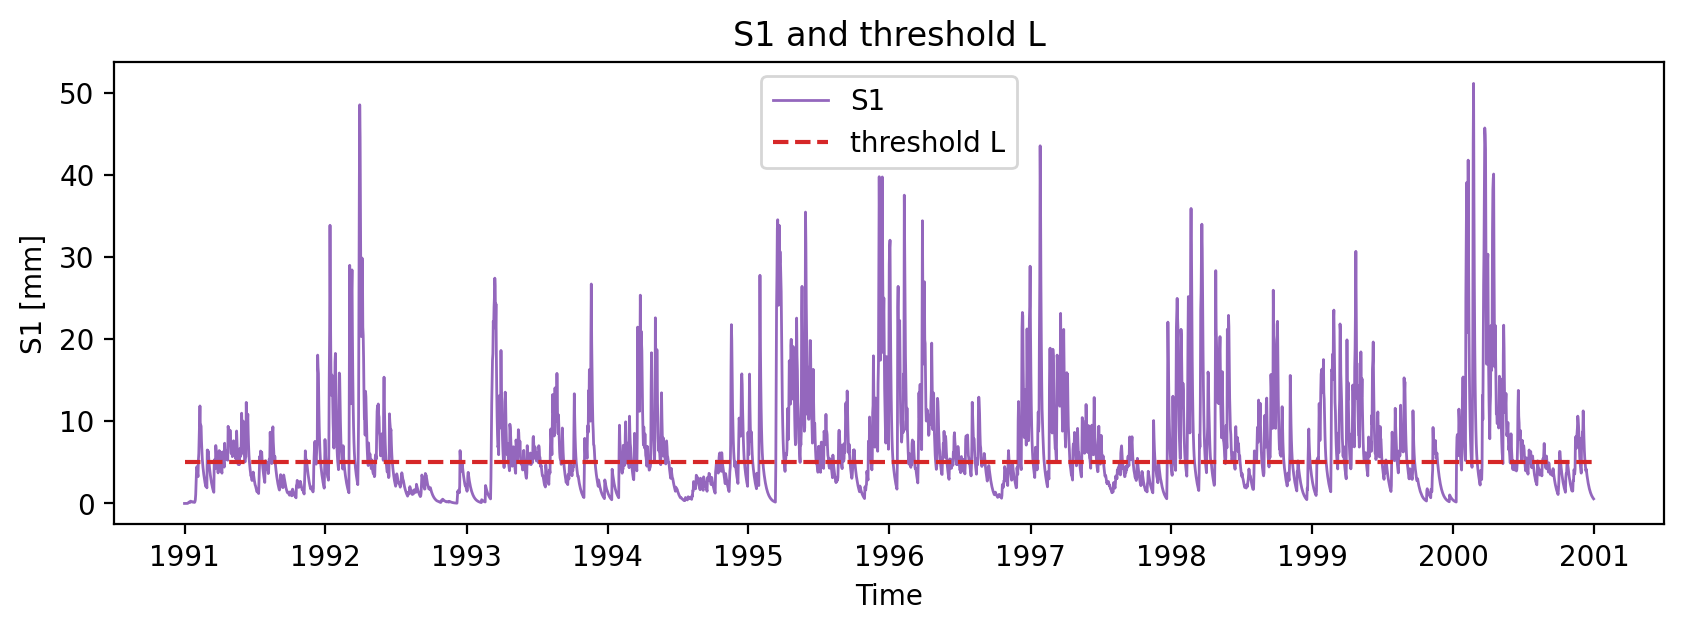

In [13]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(results["Time"], results["s1"], lw=1, label = 'S1',color = 'C4')
ax.hlines(xmin = results["Time"].min(), xmax = results["Time"].max(), y = ParamInitial['lthr'],color = 'C3',linestyles='--',label = 'threshold L')
ax.set_xlabel("Time")
ax.set_ylabel("S1 [mm]")
ax.set_title("S1 and threshold L")
ax.legend()
plt.show()